In [4]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Test

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broke

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [5]:
using Plots
using LaTeXStrings

In [6]:
function routine_plot(state::Vector{Float64}, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = cylinder_state_to_lagrange(state, config)
    Z = X .+ im*Y'
    ψ = imag.(LowRankVortex.F(Z, source))
    
    plt = plot(collect(X), collect(Y), ψ', ratio = 1.0, colorbar = false, 
                      xlim = (X[1], X[end]), 
                      ylim = (Y[1], Y[end]); levels = 10)
    
        
    θc = range(0,2π,length=201)
    zc = exp.(im*θc[1:end-1])
    plot!(real.(zc),imag.(zc),fillrange=0,fillcolor=:gray)
    
    if withvortices == true
        plot!(plt, source, markersize = 4, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

routine_plot(blobs, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true) = 
routine_plot(cylinder_lagrange_to_state(blobs, config), config, X, Y; withvortices=withvortices)


routine_plot (generic function with 2 methods)

### Configuration setup

In [83]:
# grid for evaluation
xgrid = range(-4,4,length=201)
ygrid = copy(xgrid)
zgrid = xgrid .+ im*ygrid';

# sensors on the unit circle
θsensors = range(0,2π,length=31)[1:end-1]
sensors = exp.(im*θsensors)

t0 = 0.0
tf = 2.0
tspan = (t0, tf)

# create configuration file
config_data = let Nv = 5, U = complex(0.0), 
             ss = sensors, Δt = 5e-3, δ = 1e-3,
             ϵX = 1e-2, ϵΓ = 1e-2,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Ny = length(config_data.ss)
Nx = 3*config_data.Nv

15

### Generate the truth used in the twin experiment

In [84]:
σθ = 0.05*(2*π/(config_data.Nv))
θv = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)

r0 = 3.0
σr = 0.05*r0
rv = r0 .+ σr*randn(config_data.Nv)

Γ0 = 10.0
σΓ = 0.05*Γ0
zv = rv .* exp.(im*θv)
Γv = Γ0 .+ σΓ*randn(config_data.Nv)

blobs = Vortex.Blob.(zv,Γv,config_data.δ*ones(config_data.Nv))

data = generate_data_cylinder_twin_experiment(deepcopy(blobs), t0, tf, config_data,
       "/media/mat/HDD/LowRankVortex.jl/localization/")

tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/localization/data_cylinder_twin_experiment.jld", 
                      "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  1.955, 1.96, 1.965, 1.97, 1.975, 1.98, 1.985, 1.99, 1.995, 2.0], 0.005, [3.0376901110041463, 0.08614026734728233, 9.993494871406787, 1.0314149163469648, 3.071773965661099, 10.303608412959605, -2.3831682191505363, 2.016135465314397, 10.459137595959941, -2.071240885234031, -1.898359341227598, 10.11317608315764, 0.769502578258248, -2.9203451178265385, 10.113438104362375], [3.0279009710785423 3.0405616376606397 … 2.395102894306405 2.409821057405738; 0.0817248839007632 0.07765383330011133 … 2.001726940400249 2.0251582018213554; … ; -2.913570551667286 -2.910351021515977 … -1.6240500368002908 -1.6204635588926672; 10.097920238506532 10.125776511645379 … 10.057154781900733 10.060229393441238], [-2.813932366998076 -2.8066852339703696 … -2.661611719696654 -2.6478265612523098; -2.834417258349257 -2.8363470910218966 … -2.6533671640243877 -2.654082699418259; … ; -2.773296508342652 -2.772470693742125 … -2.77087877826684

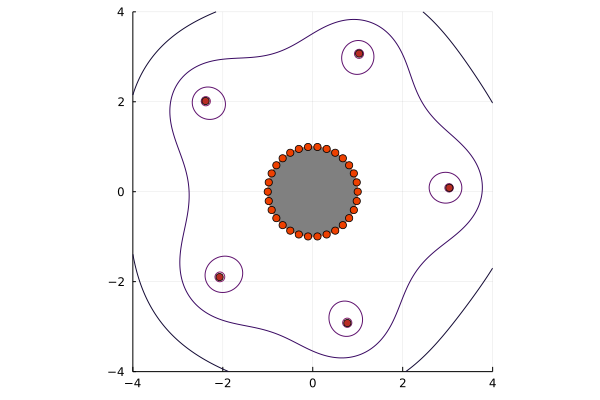

In [85]:
routine_plot(blobs, config_data, xgrid, ygrid)

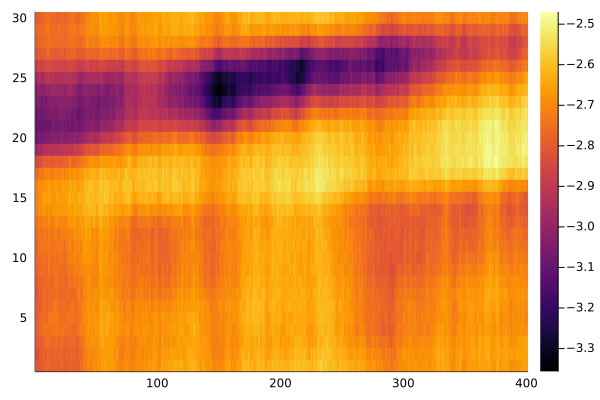

In [86]:
heatmap(data.yt)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
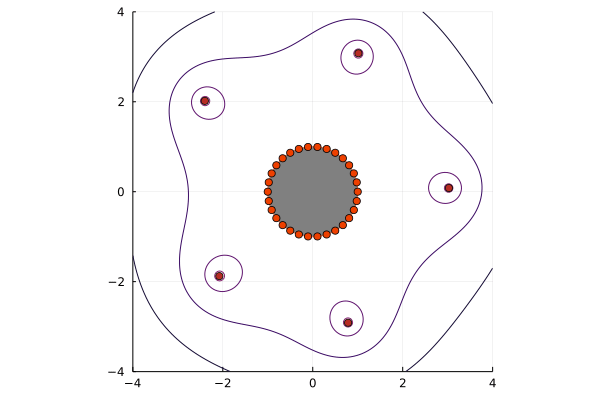

In [87]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid)
    next!(prog)
end

### Setup of the ensemble filter

In [88]:
config = deepcopy(config_data)

VortexConfig(5, 0.0 + 0.0im, ComplexF64[1.0 + 0.0im, 0.9781476007338057 + 0.20791169081775931im, 0.9135454576426009 + 0.40673664307580015im, 0.8090169943749475 + 0.5877852522924731im, 0.6691306063588582 + 0.7431448254773941im, 0.5000000000000001 + 0.8660254037844386im, 0.30901699437494745 + 0.9510565162951535im, 0.10452846326765368 + 0.9945218953682733im, -0.10452846326765333 + 0.9945218953682734im, -0.30901699437494734 + 0.9510565162951536im  …  -0.5000000000000004 - 0.8660254037844385im, -0.30901699437494756 - 0.9510565162951535im, -0.10452846326765423 - 0.9945218953682733im, 0.10452846326765299 - 0.9945218953682734im, 0.30901699437494723 - 0.9510565162951536im, 0.49999999999999933 - 0.866025403784439im, 0.6691306063588578 - 0.7431448254773946im, 0.8090169943749473 - 0.5877852522924734im, 0.9135454576426005 - 0.40673664307580093im, 0.9781476007338056 - 0.20791169081775987im], 0.005, 0.001, 0.01, 0.01, 1.0, 0.01)

In [89]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

senkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = false)
lrenkf = LREnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = false)

LREnKF  with filtered = false


In [111]:
# Generate the initial condition

Ne = 30

X0 = zeros(Ny+Nx, Ne)


for i=1:Ne
    θi = range(0,2π,length=config_data.Nv+1)[1:end-1] .+ σθ*randn(config_data.Nv)
    ri = r0 .+ σr*randn(config_data.Nv)
    zi = ri .* exp.(im*θi)
    Γi = Γ0 .+ σΓ*randn(config_data.Nv)
    
    bi = Vortex.Blob.(zi,Γi,config_data.δ*ones(config_data.Nv))
    X0[Ny+1:Ny+Nx,i] = cylinder_lagrange_to_state(bi, config_data)
end

X = deepcopy(X0);

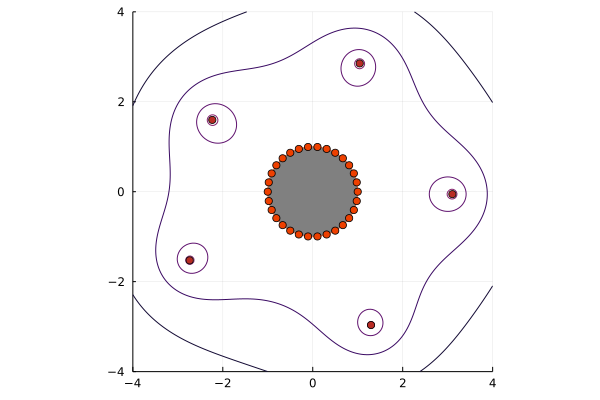

In [112]:
routine_plot(X[Ny+1:Ny+Nx,1], config_data, xgrid, ygrid)

In [113]:
timeidx = 101:401

101:401

In [114]:
@time Xf, Xa = senkf_cylinder_vortexassim(senkf, deepcopy(X0), tspan, config, data)

rmse_enkf = mean((norm.(eachcol(mean_hist(Xa)-data.xt)))[timeidx])/sqrt(size(data.x0,1))

  3.433824 seconds (2.31 M allocations: 416.122 MiB, 2.75% gc time)


0.3136748887643315

In [115]:
Lxy = Inf
Lyy = Inf

Inf

In [116]:
@time Xflocalized, Xalocalized = localized_senkf_cylinder_vortexassim(senkf, 
                                                                Lxy, Lyy, deepcopy(X0), tspan, config, data)

rmse_localized_enkf = mean(norm.(eachcol(mean_hist(Xalocalized)-data.xt))[timeidx]/sqrt(size(data.x0,1)))

  3.524731 seconds (2.35 M allocations: 442.632 MiB, 2.62% gc time)


0.8435925556747312

In [123]:
@time Xflowrank, Xalowrank, rxhist, ryhist = adaptive_lowrankenkf_cylinder_vortexassim(
                                                             lrenkf, 
                                                             deepcopy(X0), 
                                                             tspan, config, 
                                                             data; 
                                                             rxdefault = Nx,
                                                             rydefault = Ny, 
                                                             isadaptive = false,
                                                             ratio = 1.0)

rmse_lowrank = mean(norm.(eachcol(mean_hist(Xalowrank)-data.xt))[timeidx]/sqrt(size(data.x0,1)))

 15.479081 seconds (3.28 M allocations: 1.144 GiB, 0.80% gc time, 0.09% compilation time)


2.10193261908686

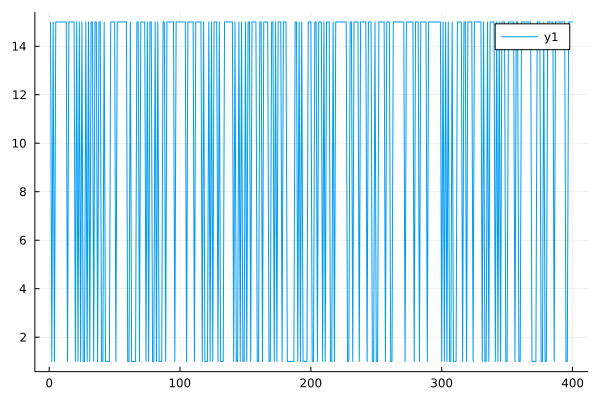

In [119]:
plot(rxhist)

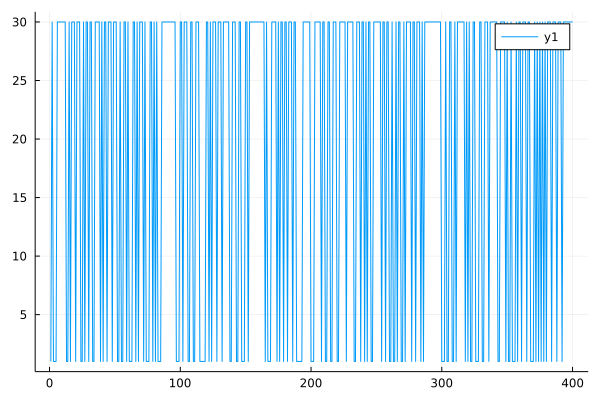

In [120]:
plot(ryhist)

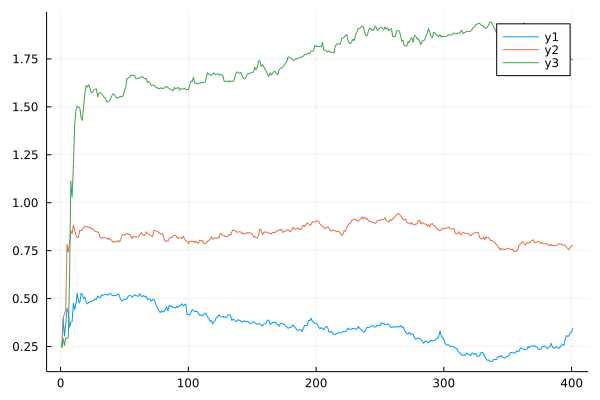

In [121]:
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)))
plot!(norm.(eachcol(mean_hist(Xalocalized)-data.xt))/sqrt(size(data.x0,1)))
plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)))


In [33]:
plt = plot(legend = false)
for i=1:Ne
    plot!(plt, h(Xa[2][:,i],0.0))
end
plt

plot!(plt, data.yt[:,2], linewidth = 10)
plt

LoadError: UndefVarError: h not defined

In [365]:
norm(mean(X0[Ny+1:Ny+Nx,:]; dims = 2)[:,1]-data.xt[:,1])

1.344460508785543

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
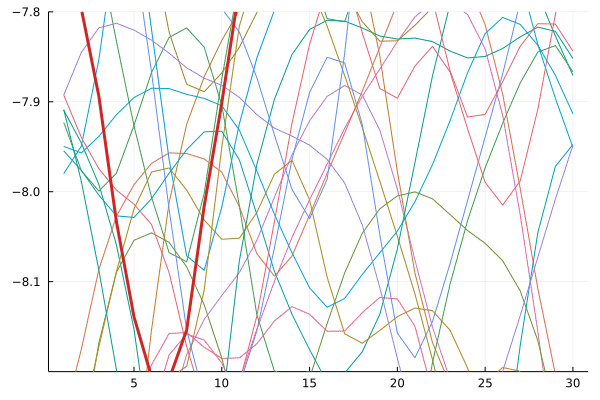

In [321]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = plot(legend = false, ylim = (-8.20, -7.8))
    for i=1:Ne
        plot!(plt, h(Xa[nsnap][:,i],0.0))
    end
    plot!(plt, data.yt[:,nsnap], linewidth = 3, color = colorant"firebrick3")
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
┌ Info: Saved animation to 
│   fn = /media/mat/HDD/LowRankVortex.jl/localization/tmp.gif
└ @ Plots /home/mat/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/media/mat/HDD/LowRankVortex.jl/localization/tmp.gif")
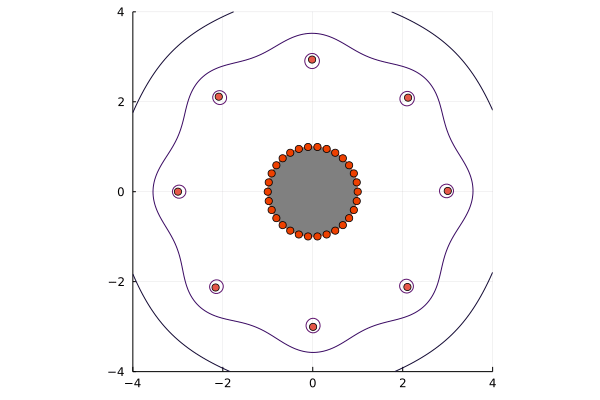

In [322]:
## Make movie animation
Δtgif = 1e-2
prog = Progress(length(t0:Δtgif:tf))

@gif for tsnap in t0:Δtgif:tf
    nsnap = ceil(Int64, tsnap/config_data.Δt)+1
    plt = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config_data, xgrid, ygrid)
    next!(prog)
end

In [59]:
J = zeros(length(config_data.ss), Nx)

@time for i=1:config_data.Nv
    dpdzi = dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[1][:,1], config_data); ϵ = config_data.δ)
    J[:,3*i-2] .= 2*real(dpdzi)  
    J[:,3*i-1] .= -2*imag(dpdzi)
    
    dpdΓi = dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[1][:,1], config_data); ϵ = config_data.δ)
    J[:,3*i] .= dpdΓi
end

  0.013955 seconds (435 allocations: 44.328 KiB, 82.32% compilation time)


In [60]:
Jbis = cylinder_analytical_jacobian_pressure(config_data.ss, 
       cylinder_state_to_lagrange(Xf[1][:,1], config_data))

30×24 Matrix{Float64}:
 0.132296    0.00401022  -0.277655  …  -0.2137      -0.00390874  -0.242944
 0.140153    0.0173255   -0.271971     -0.161277    -0.0330813   -0.219664
 0.159371    0.027041    -0.258452     -0.119829    -0.048034    -0.198365
 0.16663     0.0426447   -0.237002     -0.0858084   -0.0472335   -0.178689
 0.155342    0.0749342   -0.210264     -0.0526639   -0.0369615   -0.161887
 0.136196    0.114969    -0.184051  …  -0.0219927   -0.0262603   -0.149447
 0.117574    0.145776    -0.162596      0.0009206   -0.0198012   -0.141187
 0.1018      0.161602    -0.146636      0.0155162   -0.0181106   -0.136176
 0.0891093   0.163614    -0.135513      0.0233517   -0.0205554   -0.13359
 0.0766805   0.152219    -0.127715      0.0234286   -0.024764    -0.131732
 0.0612013   0.130179    -0.120999  …   0.0155259   -0.0271264   -0.128756
 0.0440421   0.103757    -0.114355      0.00379982  -0.0264888   -0.124902
 0.0293649   0.077484    -0.108558     -0.00674317  -0.0246832   -0.121993
 ⋮ 

In [62]:
U, Λ, V = svd(J);

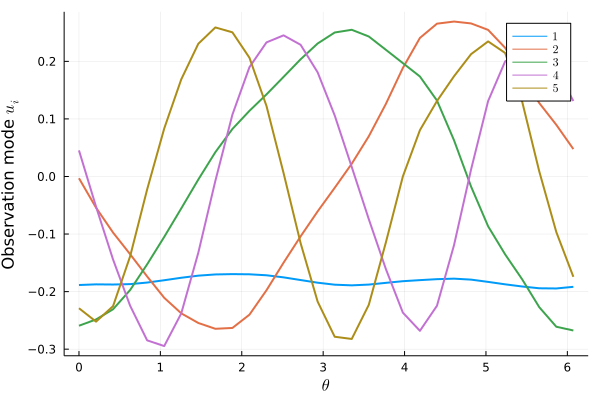

In [63]:
plt = plot(xlabel = L"\theta", ylabel = "Observation mode "*L"u_i")

for i=1:5
    plot!(plt, θsensors, U[:,i], linewidth = 2, label = latexstring(i))
end
#scatter!(plt, θsensors, zero(θsensors), markersize = 5)

plt

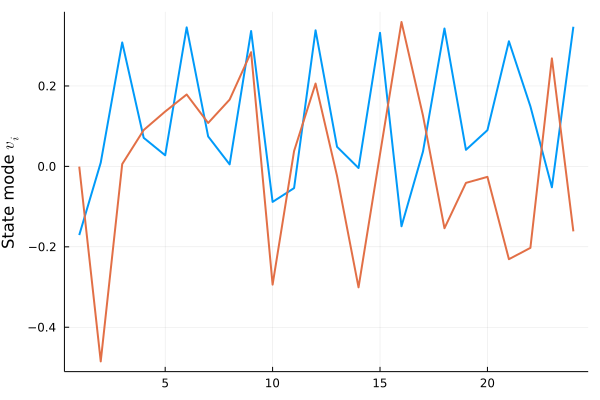

In [64]:
plt = plot(ylabel = "State mode "*L"v_i", legend = false)

for i=1:2
    plot!(plt, V[:,i], linewidth = 2)
end
plt

In [65]:
Cy = J*J'
Λy = sqrt.(svd(Cy).S)
cumsum((Λy.^2)./sum(Λy.^2))

30-element Vector{Float64}:
 0.7182305029533422
 0.8372655092175211
 0.9287090363141044
 0.9565197863093716
 0.9808578839619865
 0.9880562302735173
 0.9949439428114806
 0.9969704148410401
 0.9985690831305483
 0.9993039893206133
 0.9997539262002989
 0.9999014774374233
 0.9999615258101886
 ⋮
 0.9999998285691514
 0.9999999110441358
 0.9999999749674918
 0.9999999958095138
 0.9999999992055477
 1.0
 1.0
 1.0
 1.0
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002

In [66]:
Cx = J'*J
Λx = sqrt.(svd(Cx).S)
cumsum((Λx.^2)./sum(Λx.^2))

24-element Vector{Float64}:
 0.7182305029533422
 0.8372655092175211
 0.9287090363141046
 0.9565197863093717
 0.9808578839619867
 0.9880562302735175
 0.9949439428114808
 0.9969704148410403
 0.9985690831305485
 0.9993039893206135
 0.9997539262002992
 0.9999014774374235
 0.9999615258101888
 0.9999868344902152
 0.9999975316485479
 0.9999985914162139
 0.9999992203457081
 0.9999995604216956
 0.9999998285691516
 0.9999999110441361
 0.9999999749674922
 0.9999999958095142
 0.999999999205548
 1.0000000000000002

In [67]:
(cumsum(Λ.^2)./sum(Λ.^2))

24-element Vector{Float64}:
 0.7182305029533423
 0.8372655092175209
 0.9287090363141045
 0.9565197863093716
 0.9808578839619865
 0.9880562302735173
 0.9949439428114805
 0.9969704148410401
 0.9985690831305484
 0.9993039893206133
 0.9997539262002989
 0.9999014774374233
 0.9999615258101886
 0.999986834490215
 0.9999975316485477
 0.9999985914162136
 0.9999992203457079
 0.9999995604216952
 0.9999998285691513
 0.9999999110441358
 0.9999999749674918
 0.9999999958095138
 0.9999999992055477
 1.0

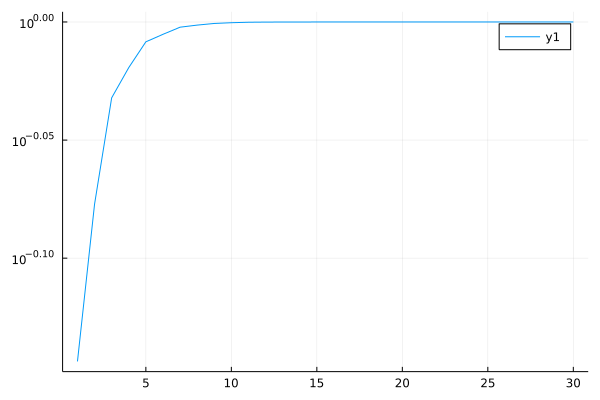

In [68]:
plot(cumsum(Λy.^2)./sum(Λy.^2), yscale = :log10)

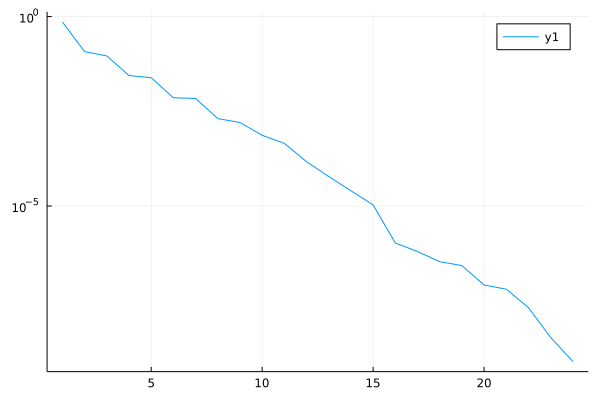

In [69]:
plot((Λ.^2)./sum(Λ.^2), yscale = :log10)

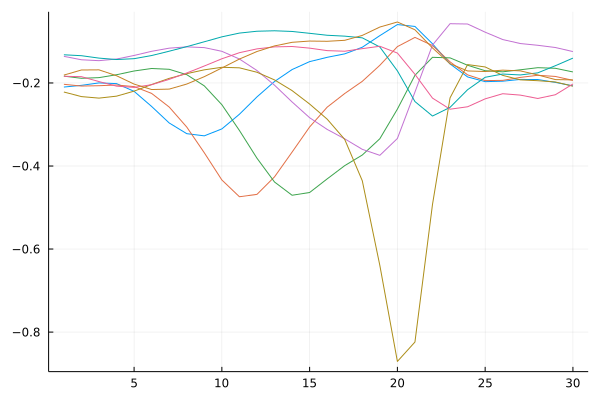

In [70]:
plt = plot(legend = false)

for i=1:config_data.Nv
    #plot!(plt, real(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    #plot!(plt, imag(dpdzv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data))))
    plot!(plt, dpdΓv(config_data.ss, i, cylinder_state_to_lagrange(Xf[end][:,1], config_data)))
end
plt

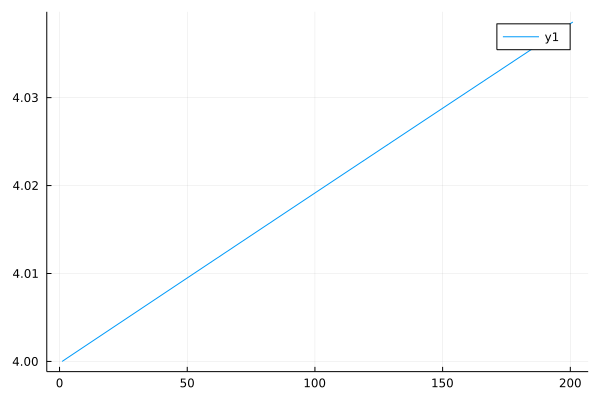

In [23]:
plot(map(xi -> xi[1]^2 + xi[2]^2, Xf))

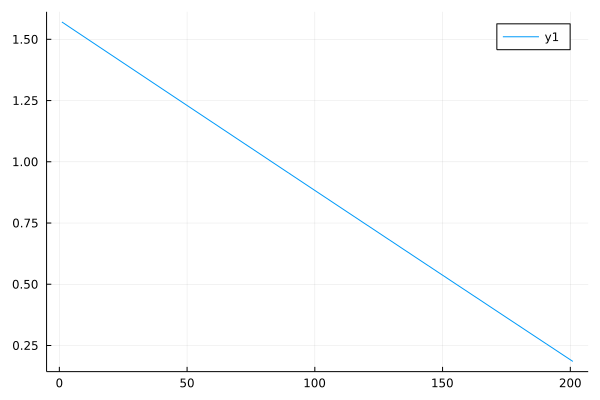

In [24]:
plot(map(xi -> atan(xi[1], xi[2]), Xf))

In [25]:
-ΓJ/(4*π^2*(abs2(zJ)*(abs2(zJ)-1)))

-0.626347670570229

In [26]:
10-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(1.5524030608054593 + 1.4966356498690878im, 1.777087057229044, 1.0e-7)
 Vortex.Blob(0.30297956811366955 - 1.5310233453394266im, 2.9950386389152985, 1.0e-7)
 Vortex.Blob(1.9533834668703678 + 1.5266552994597413im, 1.2339447083625958, 1.0e-7)
 Vortex.Blob(-1.0513133042403213 - 1.8227794557170132im, 1.6223707566499805, 1.0e-7)
 Vortex.Blob(-1.0836095985941654 + 0.7843079480127662im, 1.2450142628958365, 1.0e-7)
 Vortex.Blob(1.3467972420595151 + 0.7119955880276292im, 2.3945872015751033, 1.0e-7)
 Vortex.Blob(-1.543405087720262 - 0.948819867733115im, 2.391208846205823, 1.0e-7)
 Vortex.Blob(1.7504807284205954 - 1.4213977275321987im, 1.3496791100069796, 1.0e-7)
 Vortex.Blob(-1.2616569955408155 + 0.3668878315302502im, 1.7170363502434927, 1.0e-7)
 Vortex.Blob(0.9089535560506601 - 1.9950164010242206im, 1.6791417364879595, 1.0e-7)

LoadError: syntax: extra token "Vector" after end of expression